In [1]:
# import Craft class
from craft_text_detector import Craft
import numpy as np
import cv2 as cv

import os
import matplotlib.pyplot as plt
import math

In [2]:
#need fix for assume everyyhing is grayscale
def create_blank(width, height, rgb_color=(0, 0, 0)):

    # Create black blank image
    image = np.zeros((height, width, 3), np.uint8)

    # Since OpenCV uses BGR, convert the color first
    color = tuple(reversed(rgb_color))
    # Fill image with color
    image[:] = color

    return image


In [9]:
def function(craft, input_folder, output_folder, threshold = False):

    #how many images to read
    #iterations = 0

    for img_name in os.listdir(input_folder):

        #Create complete image path
        img_path = os.path.join(input_folder,img_name)

        if not threshold:

            img = cv.imread(img_path)
            blank_image = create_blank(img.shape[1]+10, img.shape[0]+10, rgb_color=(255, 255, 255))

        elif threshold:

            img = cv.imread(img_path, 0)
            #img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            blank_image = create_blank(img.shape[1]+10, img.shape[0]+10, rgb_color=(255, 255, 255))
            blank_image = cv.cvtColor(blank_image, cv.COLOR_BGR2GRAY)
            img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,9,3)


        prediction_result = craft.detect_text(img_path)


        # if no text was found in image, skip the image
        if(len(prediction_result["boxes"])==0):
            print("no boxxes", len(prediction_result["boxes"]))
            continue
        
        #loop troughout all boounding boxes
        for box in prediction_result["boxes"]:

            x, y, w, h = cv.boundingRect(box)
        
            rect = cv.minAreaRect(box)

            # assumptioon that width of text is always bigger then height
            if(int(rect[1][1]) > int(rect[1][0])):
                width = int(rect[1][1])
                height = int(rect[1][0])
            else:
                height = int(rect[1][1])
                width = int(rect[1][0])

            #start coordinates, horizontal coordinates
            src_pts = box.astype("float32")
            dst_pts = np.array([
                                [0, 0],
                                [width-1,0],
                                [width-1,height-1],
                                [0, height-1]  
                                ], dtype="float32")
            
            #warp image
            M = cv.getPerspectiveTransform(src_pts, dst_pts)
            warped_img = cv.warpPerspective(img, M, (width,height))

            # if warp images shape does not match box, (from missmatched width and height)
            try:
                blank_image[y:y+height, x:x+width] = warped_img
            except:
                try: 
                    blank_image[y:y+width, x:x+height] = warped_img
                except:
                    print("error 2")
                    continue

                print("error 1")
                continue
            
            #viualize the steps
            """crop = img[y:y+h, x:x+w]
            plt.figure(figsize=(10,10))
            plt.subplot(221)
            plt.axis("off")
            plt.imshow(crop)
            plt.subplot(222)
            plt.axis("off")
            plt.imshow(warped_img)"""

        #save the new image
        #cv.imwrite(output_folder + img_name,blank_image)


        #stop after X images
        #if (iterations >= 10):
        #    break
        #iterations +=1

        #visualize the orignial image and resulting image
        """plt.figure(figsize=(10,10))
        plt.subplot(221)
        plt.axis("off")
        plt.imshow(img)
        plt.subplot(222)
        plt.axis("off")
        plt.imshow(blank_image)"""
        #, cmap="gray"

        break

    craft.unload_craftnet_model()
    craft.unload_refinenet_model()




C:\Users\Johan\AppData\Local\Temp\ipykernel_19412\3140955377.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


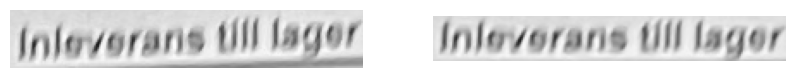

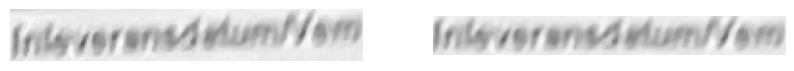

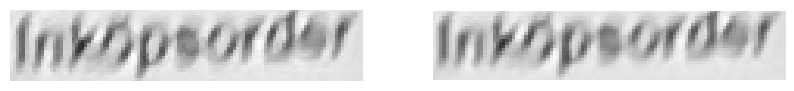

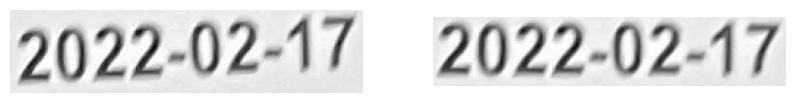

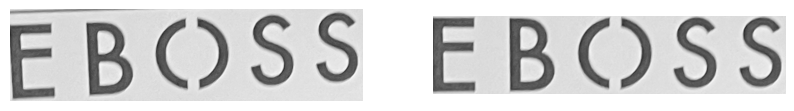

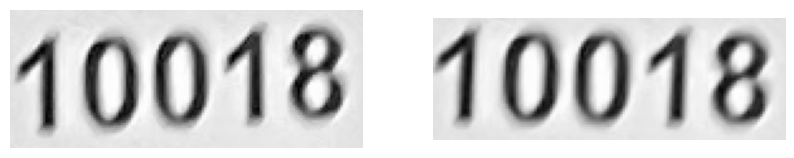

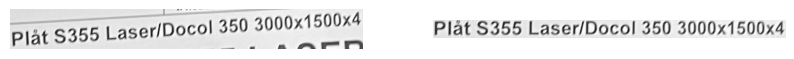

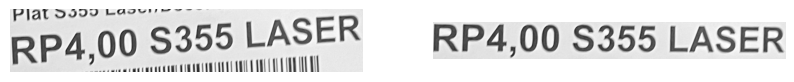

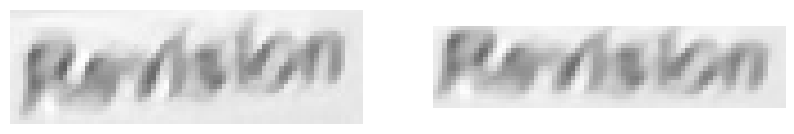

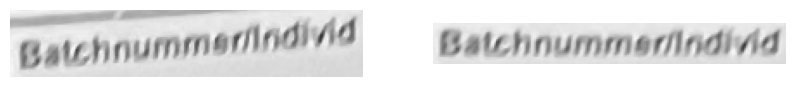

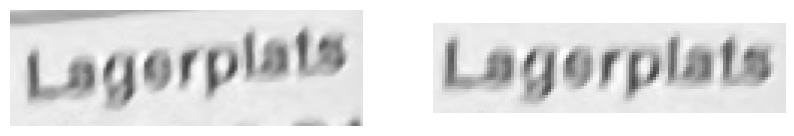

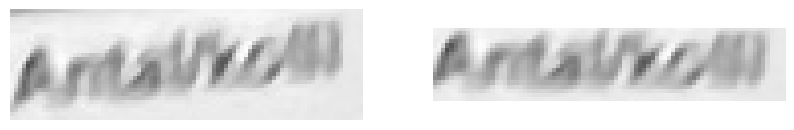

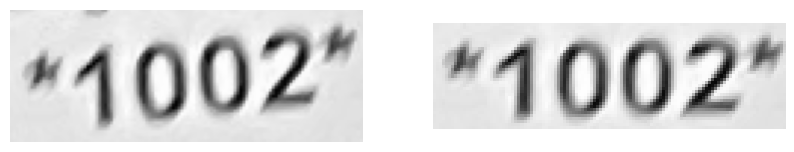

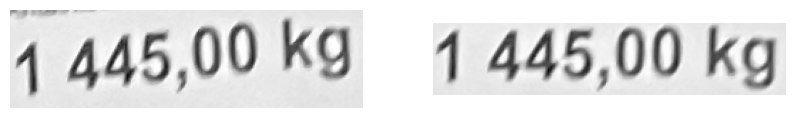

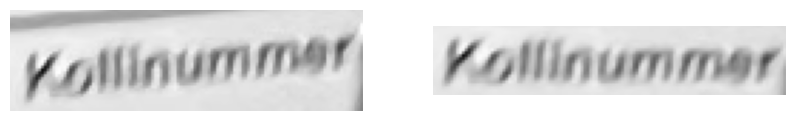

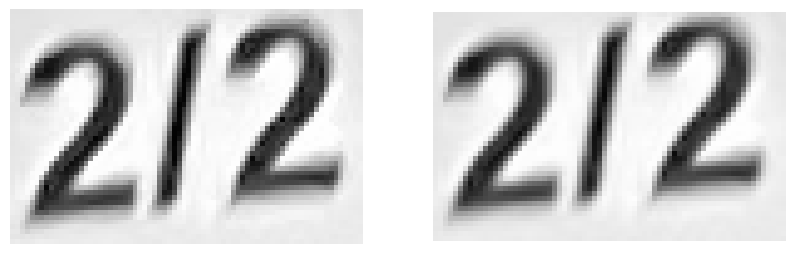

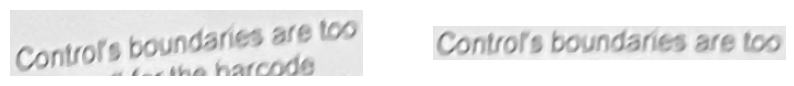

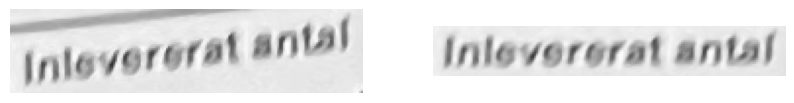

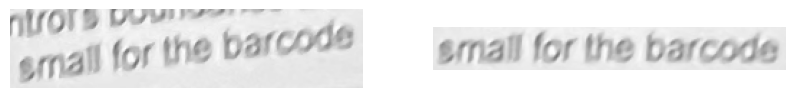

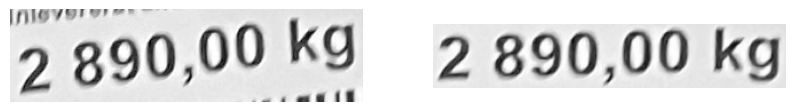

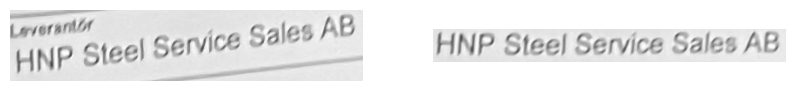

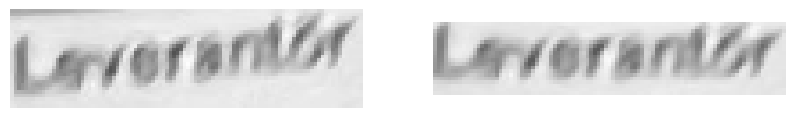

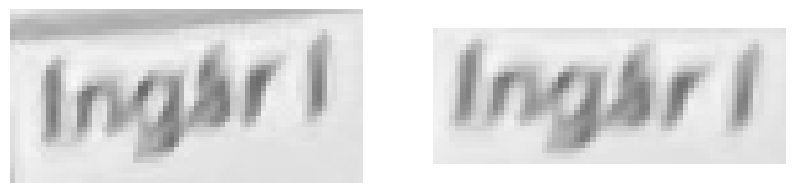

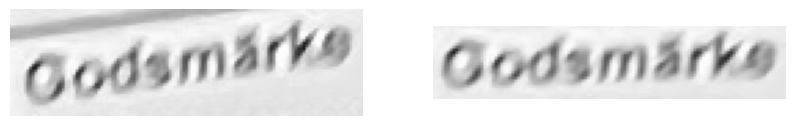

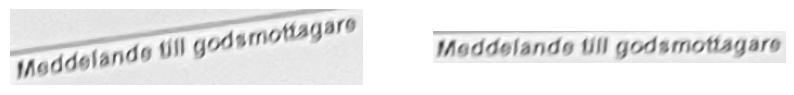

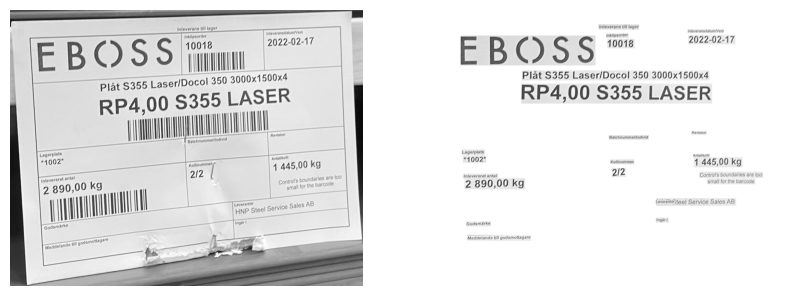

In [10]:
#Paths

output_folder = "./output/Data1_Threshold_Craft/"

input_folder = "./test/images/"

craft = Craft(output_dir=None, crop_type="poly", cuda=False)
#https://github.com/fcakyon/craft-text-detector


try:
   os.makedirs(output_folder)
except:
    pass

function(craft,input_folder,output_folder, False)


craft.unload_craftnet_model()
craft.unload_refinenet_model()

Notes

* Tested on cropped and grayscaled images,
* The requirement file is for whole course, (contains many libs which are not needed)
* This is the best result we could get. There is better warping done by CRAFT which requires saving each text box. 
* there may be some color issues of RGB, BGR, and gray when reading and saving images